In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

### 0. Prepare data

In [2]:
# read in all the words
words = open('../lecture2/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

### 1. Calculations

In [7]:
# matrix with weights 
C = torch.randn([27, 2])

#### 1.1. Get weights for certain index 

In [8]:
# just get array for letter by indexing 2d array
C[5]

tensor([ 1.0925, -0.4932])

In [9]:
# indexing of tensor
C[[5,6,7,7]]

tensor([[ 1.0925, -0.4932],
        [ 0.9561,  0.8337],
        [-0.0555,  0.6975],
        [-0.0555,  0.6975]])

In [10]:
# multiplying on one-hot encoded matrix 
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 1.0925, -0.4932])

#### 1.2. Construct embeddings 

In [11]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

#### 1.3. Initialize weights

In [12]:
W1 = torch.randn([6, 100])
b1 = torch.randn([100])

#### 1.4. Reshape embeddings 

In [13]:
# manually divide tensor by one of axis and concatenate
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

In [14]:
# automatically divide by axis and concatenate 
torch.cat(torch.unbind(emb, 1), dim=1).shape

torch.Size([32, 6])

In [15]:
# reshape with view. Really quick
emb.view((-1, 6)).shape

torch.Size([32, 6])

#### 1.5. Hidden state

In [16]:
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [17]:
# Checking broadcast
# 32 100 
#    100
# everything is ok

In [18]:
emb[:, 0, :].shape

torch.Size([32, 2])

#### 1.6. Final layer

In [19]:
W2 = torch.randn([100, 27])
b2 = torch.randn([27])

In [20]:
logits = h @ W2 + b2

In [21]:
counts = logits.exp()

In [22]:
prob = counts / counts.sum(axis=1, keepdims=True)
prob.shape

torch.Size([32, 27])

In [23]:
# check sum of probabilities for one letter
prob[0].sum()

tensor(1.)

#### 1.7. Loss 

In [24]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(12.9938)

### 2. Iteration of training process 

#### 2.1. Initialize parameters

In [25]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [26]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

#### 2.1. Forward path

In [31]:
emb = C[X]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(axis=1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697, grad_fn=<NllLossBackward0>)

##### Why better use cross_entropy

In [28]:
# 1. Quicker forward path and backward because of torch optimization
# 2. Solve problem of overflowing by subtracting max value from list 
logits = torch.tensor([1, 5, 0, 200])
counts = logits.exp()
prob = counts / counts.sum()
print(prob) # problem

logits = torch.tensor([1, 5, 0, 200]) - 200
counts = logits.exp()
prob = counts / counts.sum()
print(prob) # doesn't have a problem

tensor([0., 0., 0., nan])
tensor([0., 0., 0., 1.])


#### 2.2. Backward path 

In [32]:
for p in parameters:
  p.requires_grad = True

In [33]:
for p in parameters:
    p.grad = None
loss.backward()

for p in parameters:
    p.data += -0.01 * p.grad

### 3. Training loop

#### 3.1. Choose learning rate

In [17]:
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [18]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [19]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [20]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [21]:
for p in parameters:
  p.requires_grad = True

In [22]:
lri = []
lossi = []

In [23]:
for i in range(10000):
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward path
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward path
    for p in parameters:
        p.grad = None
    loss.backward()

    # trying different lr for choosing # evaluate by plot
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

19.522085189819336
20.28532600402832
22.65484046936035
17.749971389770508
22.613624572753906
20.02329444885254
19.856733322143555
18.595687866210938
20.286846160888672
19.343608856201172
20.00918197631836
18.86632537841797
20.351409912109375
20.43692970275879
19.476776123046875
20.26049041748047
18.31002426147461
20.056291580200195
18.416318893432617
18.45543670654297
20.26556968688965
19.350818634033203
19.3786563873291
19.718982696533203
18.989093780517578
17.861705780029297
18.781658172607422
21.103092193603516
18.944841384887695
17.83271026611328
21.221227645874023
18.76123809814453
17.7419490814209
21.001445770263672
21.11859703063965
20.953182220458984
20.239320755004883
20.669254302978516
17.063800811767578
18.35890769958496
15.505743980407715
17.843311309814453
18.710735321044922
21.961742401123047
20.28738021850586
21.431238174438477
20.21836280822754
19.26164436340332
19.731456756591797
17.946279525756836
19.755258560180664
17.392148971557617
15.569904327392578
16.33222007751

IndexError: index 1000 is out of bounds for dimension 0 with size 1000

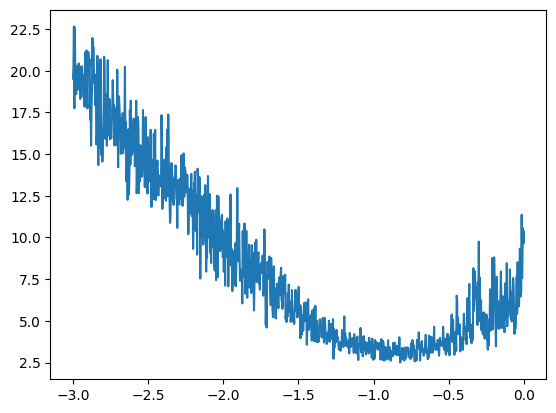

In [24]:
# See from plot the lr is good near 10^(-1)
plt.plot(lri, lossi)

#### 3.2. Train model 

#### Ways to optimize training loop
1. Count gradient for batches
2. Choose learning rate
3. Decay learning rate after time

In [25]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [26]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [15]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [16]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [17]:
for p in parameters:
  p.requires_grad = True

In [19]:
lri = []
lossi = []

In [120]:
for i in range(10000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward path
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward path
    for p in parameters:
        p.grad = None
    loss.backward()

    # trying different lr for choosing # evaluate by plot
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    # lri.append(lre[i])
    lossi.append(loss.item())

In [121]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3286, grad_fn=<NllLossBackward0>)

In [122]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3297, grad_fn=<NllLossBackward0>)

Training and dev losses are similar so we make assumption that our model is underfitted because of too small amount of parameters 

#### 3.3. Experiment with model size

In [57]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [58]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [59]:
for p in parameters:
  p.requires_grad = True

In [60]:
lossi = []
stepi = []

In [61]:
for i in range(200000):
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward path
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward path
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    stepi.append(i)
    lossi.append(loss.item())

In [62]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1469, grad_fn=<NllLossBackward0>)

In [63]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1876, grad_fn=<NllLossBackward0>)

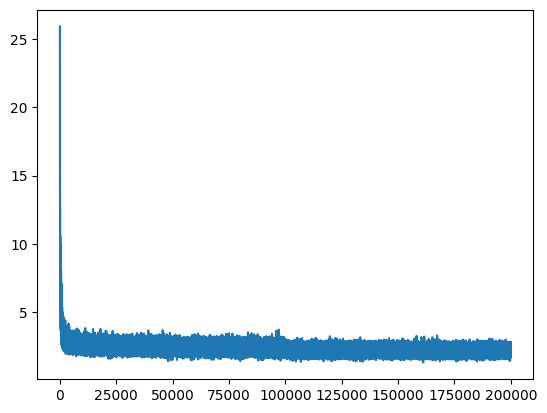

In [64]:
plt.plot(stepi, lossi)

### 4. Sampling from model

In [65]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

moha.
kayah.
see.
mad.
rylle.
emmrusendrael.
adelyn.
eliianni.
jen.
eden.
van.
nar.
kayzior.
karin.
shurergiagriel.
kin.
renlee.
jose.
casu.
zayven.
